<a href="https://colab.research.google.com/github/sonalshreya25/DeepLearning/blob/main/Assignment4_CNN_multi_class_image_classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4 - CNN Multiclass Image Classification
## Dataset used : FashionMNIST
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
### **FashionMNIST CNN Classification with LeakyReLU and Hyperparameter Tuning**
This notebook implements a Convolutional Neural Network (CNN) to classify images from the **FashionMNIST dataset** using **LeakyReLU activation**. The model is optimized with **Batch Normalization, Dropout, Learning Rate Scheduling, Automatic Mixed Precision (AMP)**, and **hyperparameter tuning using Weights & Biases (WandB Sweeps)**.



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
from torch.utils.data import DataLoader, random_split
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Check if GPU is available and set device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7c3af5a81ed0>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Using device: cpu
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7c3af5a81ed0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

## **FashionMNIST Class Labels**

Each training and test example is assigned to one of the following labels:

| Label | Category       |
|-------|--------------|
| 0     | T-shirt/top  |
| 1     | Trouser      |
| 2     | Pullover     |
| 3     | Dress        |
| 4     | Coat         |
| 5     | Sandal       |
| 6     | Shirt        |
| 7     | Sneaker      |
| 8     | Bag          |
| 9     | Ankle boot   |

### **Initializing weights and Biasess**

We start with initializing Weights & Biases (WandB) for experiment tracking, logging hyperparameters such as learning rate (0.02), model architecture (CNN), dataset (FashionMNIST), and number of epochs (10).
### **Dataloading, transformation and splitting the data**
 We downloaded the dataset from Kaggle using `kagglehub.dataset_download("zalando-research/fashionmnist")`.
We then applied data transformations to enhance generalization, including converting images to tensors, random rotations (10°), horizontal flips, and normalization to a mean of 0.5 and standard deviation of 0.5.
 The dataset came with splitted training and testing data, we further slit the training dataset into training (80%) and validation (20%) sets, with test data loaded separately.
 Next the data loaders have been created for batch processing.


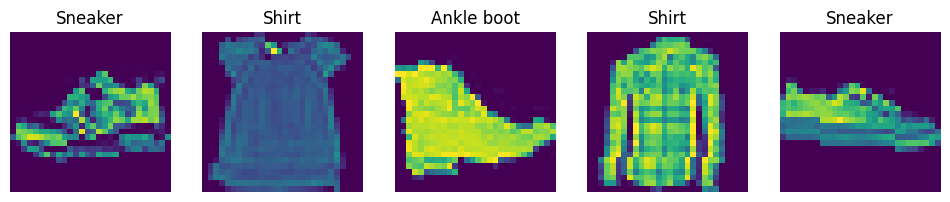

In [9]:

# Initialize Weights & Biases
wandb.init(project='CNN', entity='usf-alpha-neurons', config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "FashionMNIST",
        "epochs": 10,
    },)

# Simulate training.
epochs = 10

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("zalando-research/fashionmnist")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),  # Random rotations
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
full_trainset = torchvision.datasets.FashionMNIST(root=dataset_path, train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg.transpose((1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the class names in FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot a few images from different classes
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].numpy().transpose((1, 2, 0)))
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.show()


## **CNN Model and Improvements**

We designed and experimented with multiple variations of a Convolutional Neural Network (CNN) for image classification using the FashionMNIST dataset.

- Initially, we started with a simple architecture consisting of:
  - Two convolutional layers with `ReLU` activation
  - Max pooling layers
  - Fully connected layers

- We observed that the model had room for improvement in terms of accuracy and generalization.

- To enhance performance, we made the following changes:
  - Introduced batch normalization (`nn.BatchNorm2d`) after each convolutional layer to stabilize training, speed up convergence, and improve gradient flow.
  - Increased the number of convolutional layers from two to three.
  - Expanded the number of filters: **32 → 64 → 128**, while maintaining a **3x3 kernel size** and **padding of 1** to preserve spatial dimensions.

- We experimented with different activation functions:
  - Initially used `ReLU`, then switched to `LeakyReLU(0.1)`, which prevents dead neurons by allowing a small gradient for negative inputs.

- Tested different pooling strategies:
  - Found that `MaxPool2d(2,2)` effectively reduces spatial dimensions while preserving important features.

- To reduce overfitting:
  - Added a dropout layer (`nn.Dropout(0.3)`) before the fully connected layers.
  - Experimented with different dropout rates and found **0.3** to be a good balance between regularization and retaining information.

- For the fully connected layers:
  - Started with a **single dense layer** but later expanded to **two layers**.
  - `fc1` maps features to **128 neurons**.
  - `fc2` outputs **10 class predictions**.
  - Flattened the feature maps before passing them into these layers.

- These optimizations improved **accuracy and generalization**, making the model more robust.


Overall, through these iterations, we optimized our CNN architecture by incorporating batch normalization, dropout, LeakyReLU activation, and an increasing number of filters across layers, achieving improved accuracy and generalization.


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.LeakyReLU(0.1)(self.bn1(self.conv1(x))))
        x = self.pool(nn.LeakyReLU(0.1)(self.bn2(self.conv2(x))))
        x = self.pool(nn.LeakyReLU(0.1)(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(nn.LeakyReLU(0.1)(self.fc1(x)))
        x = self.fc2(x)
        return x

### **Model, Loss and Optimizer**
* We used **Cross-Entropy Loss** to evaluate the model's performance. It is particularly effective for multi-class classification problems like FashionMNIST, where the model predicts a probability distribution over multiple classes.
* The **AdamW optimizer** is used to update the model's parameters during training, with weight decay for regularization.
* A learning rate scheduler is set up to reduce the learning rate by half after every 5 epochs to help the model converge more efficiently.

In [11]:
# Model, Loss, and Optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


### **Training Function with AMP**
* **Model Setup and Mixed Precision**: We initialize the model and use GradScaler() for mixed precision training, which reduces memory usage and speeds up computation.

* **Training Loop**: For each epoch, we loop through the training batches, move the data to the device, compute the forward pass, calculate the loss, and perform backpropagation with mixed precision.

* **Optimizer and Scheduler**: After calculating gradients, we update the model weights using the optimizer, and the learning rate is adjusted by the scheduler.

* **Validation and Logging**: After each epoch, we evaluate the model on the validation set, calculate validation loss and accuracy, and log the metrics to Weights and Biases for monitoring.


In [5]:
# Training function with AMP
def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10):
    model.train()
    scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        val_loss, val_accuracy = evaluate_model(model, valloader)
        scheduler.step()
   # Log metrics to WandB
        wandb.log({'epoch': epoch+1, 'loss': avg_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy})
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')




### **Evaluation Function**
* **Set Model to Evaluation Mode**: We set the model to evaluation mode and disable gradient computation using torch.no_grad() to save memory during inference.

* **Track Loss and Correct Predictions**: For each batch, we calculate the loss and count the correct predictions by comparing model outputs to the true labels.

* **Return Average Loss and Accuracy**: After evaluating all batches, the function returns the average loss and the accuracy of the model on the dataset.

In [6]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy



### **Training and Evaluation**
* **Train the Model**: The train_model function trains the model using training data, loss function, optimizer, and scheduler for the specified number of epochs.

* **Evaluate on Test Set**: After training, the model is evaluated on the test dataset to calculate the test loss and accuracy.

* **Log and Print Results**: Test results (loss and accuracy) are logged to Weights and Biases (WandB) and printed to the console for tracking.

In [7]:
# Run training and evaluation
train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10)
test_loss, test_accuracy = evaluate_model(model, testloader)

# Log final test results
wandb.log({'Test Loss': test_loss, 'Test Accuracy': test_accuracy})
print(f'Accuracy on test set: {test_accuracy:.2f}%')


<ipython-input-5-701f7f45f771>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision training
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-5-701f7f45f771>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 0.4999, Val Loss: 0.3538, Val Accuracy: 86.93%
Epoch 2, Loss: 0.3248, Val Loss: 0.3103, Val Accuracy: 88.91%
Epoch 3, Loss: 0.2820, Val Loss: 0.2911, Val Accuracy: 89.17%
Epoch 4, Loss: 0.2588, Val Loss: 0.2805, Val Accuracy: 89.49%
Epoch 5, Loss: 0.2401, Val Loss: 0.2708, Val Accuracy: 90.17%
Epoch 6, Loss: 0.2020, Val Loss: 0.2474, Val Accuracy: 91.11%
Epoch 7, Loss: 0.1921, Val Loss: 0.2290, Val Accuracy: 91.92%
Epoch 8, Loss: 0.1832, Val Loss: 0.2286, Val Accuracy: 91.76%
Epoch 9, Loss: 0.1772, Val Loss: 0.2302, Val Accuracy: 91.74%
Epoch 10, Loss: 0.1707, Val Loss: 0.2225, Val Accuracy: 91.82%
Accuracy on test set: 91.37%


### **Hyperparameter tuning with Weights & Biases**

In [12]:
sweep_config = {
    'method': 'grid',  # 'random' or 'grid'
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'batch_size': {'values': [32, 64, 128]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'optimizer': {'values': ['adam', 'sgd']}
    }
}
sweep_id = wandb.sweep(sweep_config, project='CNN', entity='usf-alpha-neurons')

Create sweep with ID: y3pk5a2s
Sweep URL: https://wandb.ai/usf-alpha-neurons/CNN/sweeps/y3pk5a2s


In [13]:
def sweep_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        model = CNN().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate) if config.optimizer == 'adam' else optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        train_model(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=10)

wandb.agent(sweep_id, function=sweep_train, count=5)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: x6rus8m6 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_config.py", line 165, in __getattr__
    return self.__getitem__(key)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'optimizer'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-13-801c957f4b04>", line 5, in sweep_train
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate) if config.optimizer == 'adam' else optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
                                                                           

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7c3af5a81ed0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe